## Practicing Supervised Regression and Classification Algorithms
### Random Forest, Gradient Boosting, Xtreme Gradient Boosting and Support Vector Machine(SVM)

### Problem Statement
The data set of 10,000 students who enrolled in an online course (MOOC) is given. It contains several attributes related to the events/activities on the
course portal. It also has a ground truth or label called “dropout”. Build the models to predict and analyze which student may continue the course till the end (dropout=0) and which student may discontinue the course (dropout=1).
Details of Attributes: (File: student_dropout.csv)
1) n_events_lst_wk: Number of events in the last week
2) days_course_strt_access1: Number of days between the end of the course and the last day of access of the course material
3) n_access_lst2_wk: Number of accesses in the last two weeks
4) n_events: Total number of events
5) unique_days_accessed: The number of unique days accessed
6) n_access: Total number of accesses till the prediction time
7) n_access_lst_wk: Total number of accesses in the last week
8) n_navigate: Total number of page navigations
9) n_page_close: Total number of page closes
10) n_problem: Total number of problems solved
11) n_videos: Total number of videos watched
12) days_course_end_access_lst: From the start date of the course, after how many days a student accessed course content
13) n_discussion: Total number of discussions on forum
14) n_wiki: Total number of wiki views
- Analyze the data
    - Find out if there are any attributes with correlation more than 0.50
    - Visualize the attributes using – Kernel density estimation (KDE/Histogram plots) or other relevant plots – Write down your observations
- Curate the data (if required)
    - Identify the missing values and fill them with an appropriate method, if there are any missing values
- Build classifiers/models using Random Forest, GBM, XGBOOST and SVM.
    - Build the model & Perform 5-fold cross validation
    - Evaluate the model using accuracy, confusion matrix, precision, recall and F1
    - Compare the performance of all the models against test data (choose an appropriate train and test ratio)
    - Perform hyper-parameter tuning
- Identify the top 5 important predictors and visualize the importance scores
- Analyze the results

- NOTE: Use less number of samples if your machine does not have enough resources.

In [1]:
# Importing necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
# Reading the dataset:
df = pd.read_csv("student_dropout.csv")

In [3]:
# Top 5 records:
df.head()

,student_id,n_videos,n_navigate,n_access,n_problem,n_page_close,n_discussion,n_wiki,n_events,n_events_lst_wk,n_access_lst_wk,n_access_lst2_wk,days_course_strt_access1,days_course_end_access_lst,unique_days_accessed,dropout
0,1.0,29,25,107,87,66,0,0,314,111,34,87,2.0,0.0,14,0
1,3.0,9,14,79,148,22,26,0,298,95,28,43,0.0,1.0,9,0
2,4.0,4,15,64,6,10,0,0,99,0,0,14,3.0,9.0,9,0
3,5.0,86,30,226,189,87,34,0,652,197,63,83,2.0,0.0,11,0
4,6.0,2,5,12,2,2,0,0,23,23,12,12,27.0,1.0,2,0


In [4]:
# Shape
df.shape

(9999, 16)

In [5]:
# Target data
df["dropout"].value_counts()

1    5432
0    4567
Name: dropout, dtype: int64

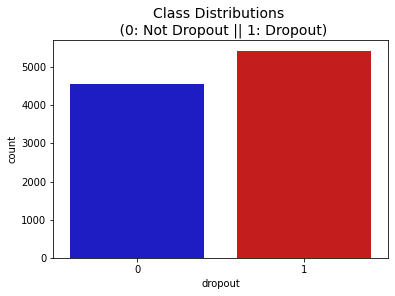

In [6]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x='dropout', data=df, palette=colors)
plt.title('Class Distributions \n (0: Not Dropout || 1: Dropout)', fontsize=14)
plt.show()

- Our dataset is **Balanced.**

In [7]:
# TOtal number of unique values in "student_id" feature:
df["student_id"].nunique()

9998

- As "student_id" feature is just id of each students. It's not relevant for predicting whether the student dropped or not. So we remove this feature. 

In [8]:
# Removing "student_id" feature:
df.drop("student_id", axis=1, inplace=True)

In [9]:
# Datatypes:
df.dtypes

n_videos                        int64
n_navigate                      int64
n_access                        int64
n_problem                       int64
n_page_close                    int64
n_discussion                    int64
n_wiki                          int64
n_events                        int64
n_events_lst_wk                 int64
n_access_lst_wk                 int64
n_access_lst2_wk                int64
days_course_strt_access1      float64
days_course_end_access_lst    float64
unique_days_accessed            int64
dropout                         int64
dtype: object

In [10]:
# Statistical Details:
df.describe()

,n_videos,n_navigate,n_access,n_problem,n_page_close,n_discussion,n_wiki,n_events,n_events_lst_wk,n_access_lst_wk,n_access_lst2_wk,days_course_strt_access1,days_course_end_access_lst,unique_days_accessed,dropout
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9012.000000,9012.000000,9999.000000,9999.000000
mean,16.280728,18.601160,67.129513,29.416742,26.039904,19.273927,1.781178,178.523152,43.513151,17.100510,33.299030,6.626165,8.291944,5.807781,0.543254
std,24.768973,23.119335,91.105147,61.989938,34.125782,100.492000,8.513437,258.436187,81.036240,31.339844,53.167982,7.568175,8.787298,4.988550,0.498150
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,4.000000,8.000000,0.000000,2.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000
50%,7.000000,12.000000,39.000000,8.000000,12.000000,1.000000,0.000000,101.000000,7.000000,3.000000,13.000000,4.000000,4.000000,4.000000,1.000000
75%,22.000000,25.000000,91.000000,31.000000,39.000000,12.000000,1.000000,240.000000,59.000000,23.000000,48.000000,10.000000,14.000000,9.000000,1.000000
max,399.000000,649.000000,2163.000000,948.000000,400.000000,4360.000000,554.000000,5289.000000,1554.000000,655.000000,1099.000000,29.000000,29.000000,30.000000,1.000000


By above statistical analysis we conclude that,
- Their are **missing values** present in dataset.
- Their are **outliers** present in dataset.

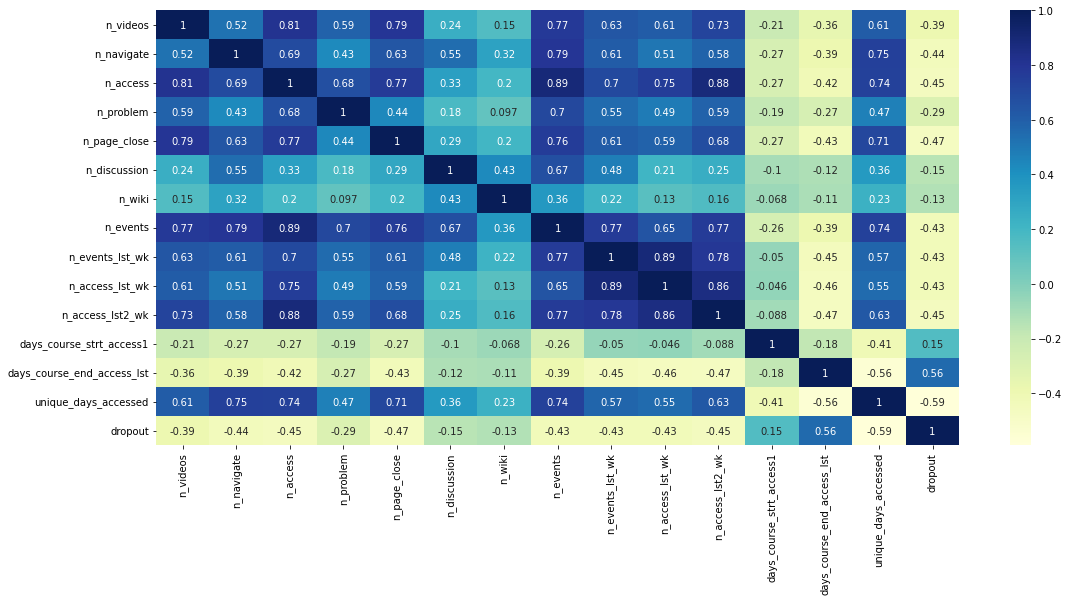

In [11]:
# Correlation using Heatmap:
plt.figure(figsize=(18,8))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
plt.show()

As we can see that, 
- their are highly **multicollinearity** present in the dataset.

Let's find the all the attributes with correlation more than 0.50

In [12]:
corr_features = set()
corr_mat = df.corr()

for i in range(len(corr_mat.columns)):
    for j in range(i):
        if corr_mat.iloc[i, j] > 0.5:
            corr_features.add(corr_mat.columns[i])
            
            print(round(corr_mat.iloc[i, j],2), "=", corr_mat.columns[i], "&", corr_mat.columns[j])

0.52 = n_navigate & n_videos
0.81 = n_access & n_videos
0.69 = n_access & n_navigate
0.59 = n_problem & n_videos
0.68 = n_problem & n_access
0.79 = n_page_close & n_videos
0.63 = n_page_close & n_navigate
0.77 = n_page_close & n_access
0.55 = n_discussion & n_navigate
0.77 = n_events & n_videos
0.79 = n_events & n_navigate
0.89 = n_events & n_access
0.7 = n_events & n_problem
0.76 = n_events & n_page_close
0.67 = n_events & n_discussion
0.63 = n_events_lst_wk & n_videos
0.61 = n_events_lst_wk & n_navigate
0.7 = n_events_lst_wk & n_access
0.55 = n_events_lst_wk & n_problem
0.61 = n_events_lst_wk & n_page_close
0.77 = n_events_lst_wk & n_events
0.61 = n_access_lst_wk & n_videos
0.51 = n_access_lst_wk & n_navigate
0.75 = n_access_lst_wk & n_access
0.59 = n_access_lst_wk & n_page_close
0.65 = n_access_lst_wk & n_events
0.89 = n_access_lst_wk & n_events_lst_wk
0.73 = n_access_lst2_wk & n_videos
0.58 = n_access_lst2_wk & n_navigate
0.88 = n_access_lst2_wk & n_access
0.59 = n_access_lst2_wk &

In [13]:
df.columns

Index(['n_videos', 'n_navigate', 'n_access', 'n_problem', 'n_page_close',
       'n_discussion', 'n_wiki', 'n_events', 'n_events_lst_wk',
       'n_access_lst_wk', 'n_access_lst2_wk', 'days_course_strt_access1',
       'days_course_end_access_lst', 'unique_days_accessed', 'dropout'],
      dtype='object')

##### n_videos

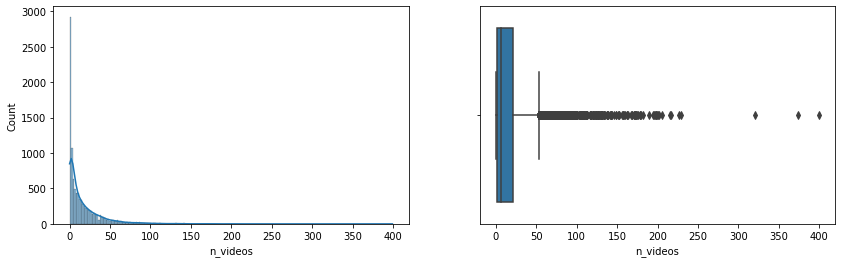

In [14]:
# n_videos
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='n_videos', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='n_videos')
plt.show()

- n_videos feature is **Right skewed.**
- **Outliers** is present.

##### n_navigate

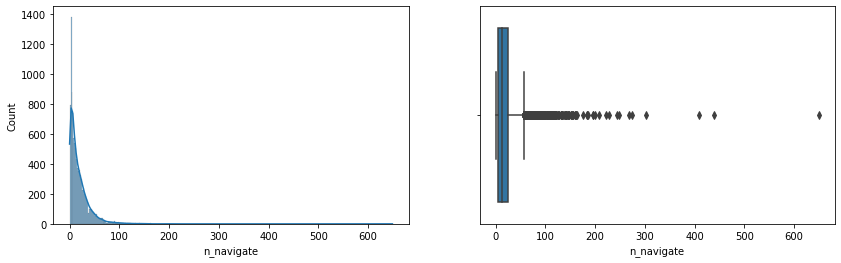

In [15]:
# n_navigate
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='n_navigate', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='n_navigate')
plt.show()

- n_navigate feature is **Right skewed.**
- **Outliers** is present.

##### n_access

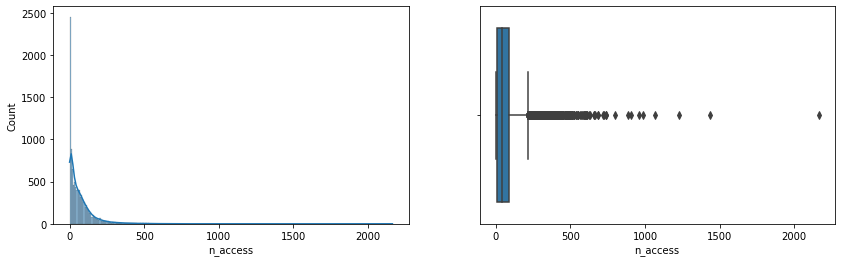

In [16]:
# n_access
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='n_access', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='n_access')
plt.show()

- n_access feature is **Right skewed.**
- **Outliers** is present.

##### n_problem

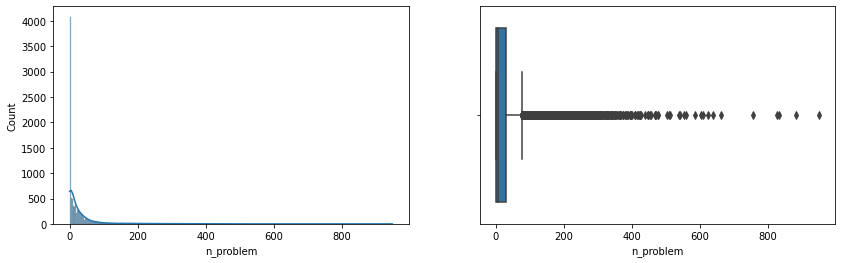

In [17]:
# n_problem
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='n_problem', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='n_problem')
plt.show()

- n_problem feature is **Right skewed.**
- **Outliers** is present.

##### n_page_close

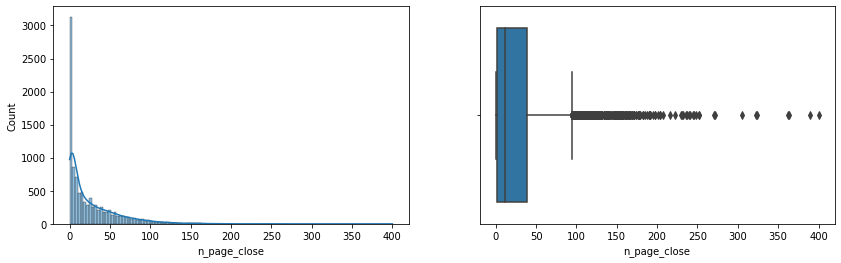

In [18]:
# n_page_close
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='n_page_close', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='n_page_close')
plt.show()

- n_page_close feature is **Right skewed.**
- **Outliers** is present.

##### n_discussion

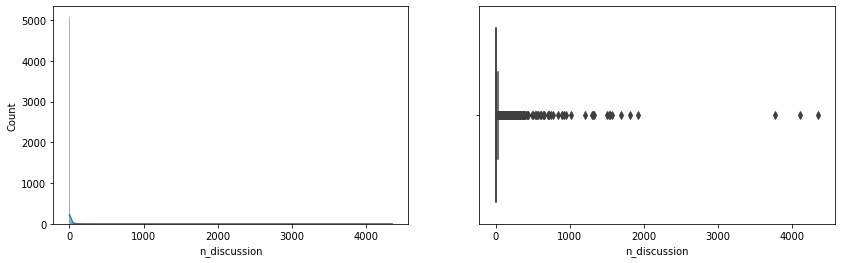

In [19]:
# n_discussion
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='n_discussion', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='n_discussion')
plt.show()

- n_discussion feature is **Right skewed.**
- **Outliers** is present.

##### n_wiki

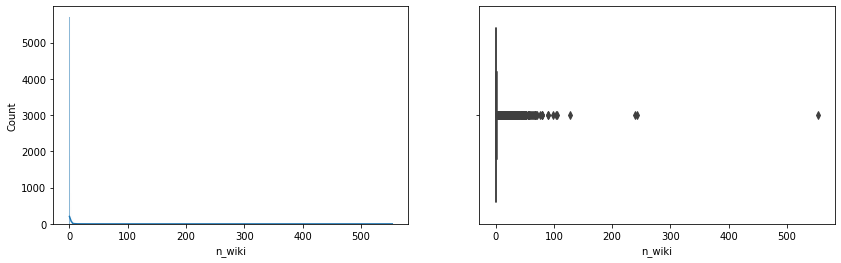

In [20]:
# n_wiki
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='n_wiki', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='n_wiki')
plt.show()

- n_wiki feature is **Right skewed.**
- **Outliers** is present.

##### n_events

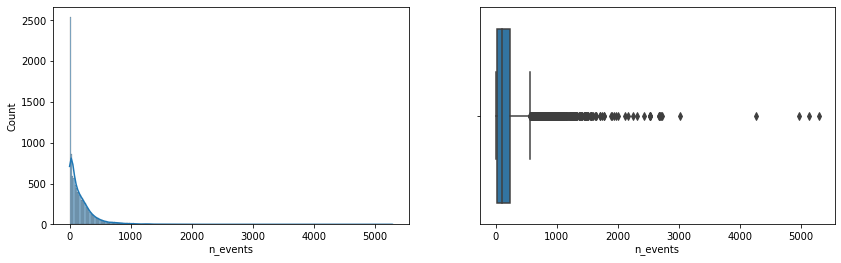

In [21]:
# n_events
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='n_events', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='n_events')
plt.show()

- n_events feature is **Right skewed.**
- **Outliers** is present.

##### n_events_lst_wk

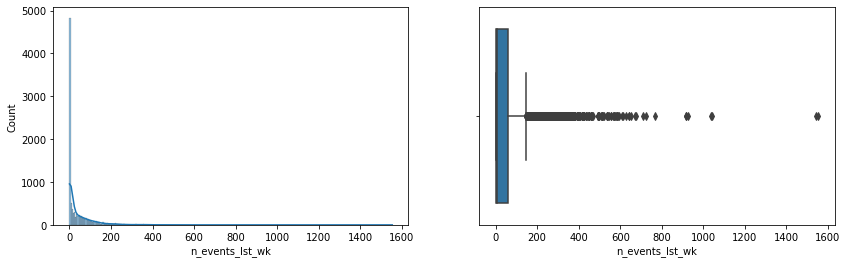

In [22]:
# n_events_lst_wk
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='n_events_lst_wk', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='n_events_lst_wk')
plt.show()

- n_events_lst_wk feature is **Right skewed.**
- **Outliers** is present.

##### n_access_lst_wk

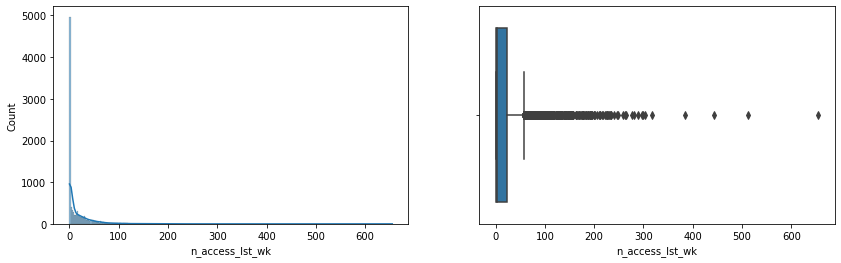

In [23]:
# n_access_lst_wk
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='n_access_lst_wk', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='n_access_lst_wk')
plt.show()

- n_access_lst_wk feature is **Right skewed.**
- **Outliers** is present.

##### n_access_lst2_wk

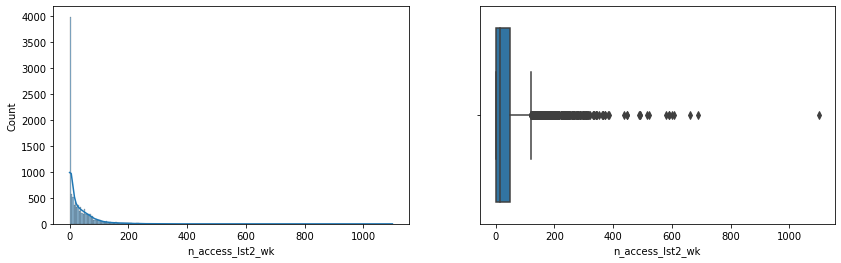

In [24]:
# n_access_lst2_wk
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='n_access_lst2_wk', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='n_access_lst2_wk')
plt.show()

- n_access_lst2_wk feature is **Right skewed.**
- **Outliers** is present.

##### days_course_strt_access1

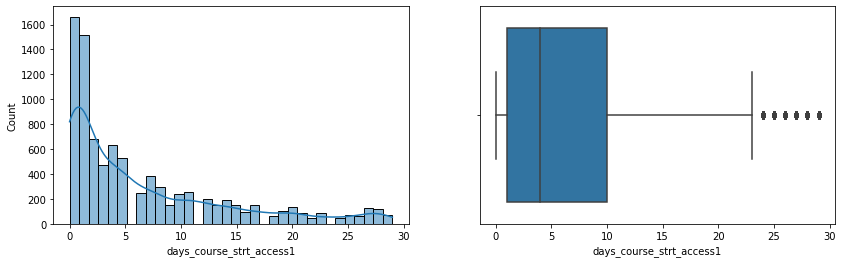

In [25]:
# days_course_strt_access1
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='days_course_strt_access1', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='days_course_strt_access1')
plt.show()

- days_course_strt_access1 feature is **Right skewed.**
- **Outliers** is present.

##### days_course_end_access_lst

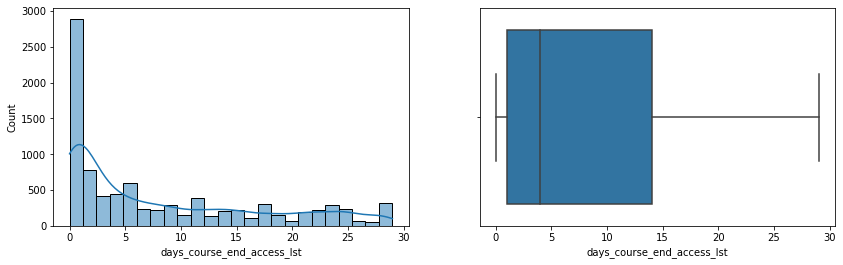

In [26]:
# days_course_end_access_lst
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='days_course_end_access_lst', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='days_course_end_access_lst')
plt.show()

- days_course_end_access_lst feature is **Right skewed.**

##### unique_days_accessed

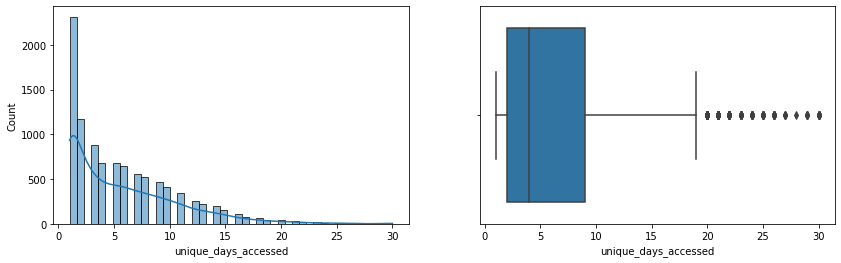

In [27]:
# unique_days_accessed
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='unique_days_accessed', kde=True)

plt.subplot(1,2,2)
sns.boxplot(data=df, x='unique_days_accessed')
plt.show()

- unique_days_accessed feature is **Right skewed.**
- **Outliers** is present.

- **All the features are Rightly Skewed distribution.**

### Curating the Data

In [159]:
# Finding null values:

df.isnull().sum()

student_id                      1
n_videos                        0
n_navigate                      0
n_access                        0
n_problem                       0
n_page_close                    0
n_discussion                    0
n_wiki                          0
n_events                        0
n_events_lst_wk                 0
n_access_lst_wk                 0
n_access_lst2_wk                0
days_course_strt_access1      987
days_course_end_access_lst    987
unique_days_accessed            0
dropout                         0
dtype: int64

In [160]:
# Finding the particular student with Student_id as null value.

df[df['student_id'].isna()]

,student_id,n_videos,n_navigate,n_access,n_problem,n_page_close,n_discussion,n_wiki,n_events,n_events_lst_wk,n_access_lst_wk,n_access_lst2_wk,days_course_strt_access1,days_course_end_access_lst,unique_days_accessed,dropout
4810,NaN,6,9,58,18,15,5,0,111,25,10,10,3.0,4.0,6,1


In [161]:
# Filling the null value with a unique id so that the data for that particular student can be used for furthur analysis.

df["student_id"].fillna(df["student_id"] == 4810, inplace=True)

In [162]:
# Verifying if there are any null values left

df[df['student_id'].isna()]

,student_id,n_videos,n_navigate,n_access,n_problem,n_page_close,n_discussion,n_wiki,n_events,n_events_lst_wk,n_access_lst_wk,n_access_lst2_wk,days_course_strt_access1,days_course_end_access_lst,unique_days_accessed,dropout


In [163]:
# To see if the ID given is unique

df["student_id"].nunique()

9999

#### Also we can see from the data,

- **days_course_strt_access1** and **days_course_end_access_lst** has 987 missing values each.
- Since there are many outiers present in the data we will use Median values to fill in the Null/Missing values.

In [164]:
# Finding Median values. 

print("Median of days_course_strt_access1:", df["days_course_strt_access1"].median())
print("Median of days_course_end_access_lst:", df["days_course_end_access_lst"].median())

Median of days_course_strt_access1: 4.0
Median of days_course_end_access_lst: 4.0


In [165]:
df["days_course_strt_access1"].fillna(df["days_course_strt_access1"].median(), inplace=True)

In [166]:
df["days_course_end_access_lst"].fillna(df["days_course_end_access_lst"].median(), inplace=True)

In [167]:
# Checking if there are still any missing values

df.isnull().sum()

student_id                    0
n_videos                      0
n_navigate                    0
n_access                      0
n_problem                     0
n_page_close                  0
n_discussion                  0
n_wiki                        0
n_events                      0
n_events_lst_wk               0
n_access_lst_wk               0
n_access_lst2_wk              0
days_course_strt_access1      0
days_course_end_access_lst    0
unique_days_accessed          0
dropout                       0
dtype: int64

In [168]:
# Dropping student_id feature as it is not require for furthur analysis
df.drop(['student_id'], axis=1, inplace=True)

In [169]:
# Creating Independent and Dependent categories:
X = df.iloc[:, :14]
Y = df.iloc[:, 14]

In [170]:
# Using RobustScaler is less prone to outliers (we have huge Outliers in our data).

rob_scaler = RobustScaler()

In [171]:
x = rob_scaler.fit_transform(X)

In [172]:
# Train-Test Spilt:
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size = 0.75, random_state=8)

### Build classifiers/models using Random Forest, GBM, XGBOOST and SVM.

### Using Random Forest

In [173]:
rf = RandomForestClassifier()

In [174]:
# Using k-fold cross validation for 5 - folds:

y_train_rf_K = cross_val_predict(rf, x_train, y_train, cv=5)

In [251]:
# For K-fold cross Validation

print("Simple Accuracy :", round(accuracy_score(y_train, y_train_rf_K),2)*100,"%")
print("Precision :", round(precision_score(y_train, y_train_rf_K),2))
print("Recall :", round(recall_score(y_train, y_train_rf_K),2))
print("F1_Score :", round(f1_score(y_train, y_train_rf_K),2))

Simple Accuracy : 84.0 %
Precision : 0.86
Recall : 0.85
F1_Score : 0.85


In [179]:
print("Confusion Matrix :")
print(confusion_matrix(y_train, y_train_rf_K))

Confusion Matrix :
[[ 950  192]
 [ 208 1149]]


In [180]:
rf.fit(x_train, y_train)

RandomForestClassifier()

In [181]:
y_pred_rf = rf.predict(x_test)

In [248]:
# For Random Forest

print("Accuracy :", round(accuracy_score(y_test, y_pred_rf), 2)*100,"%")
print("Precision :", round(precision_score(y_test, y_pred_rf), 2))
print("Recall :", round(recall_score(y_test, y_pred_rf), 2))
print("f1_Score :", round(f1_score(y_test, y_pred_rf), 2))

Accuracy : 82.0 %
Precision : 0.83
Recall : 0.83
f1_Score : 0.83


In [183]:
print("Confusion Matrix :")
print(confusion_matrix(y_test, y_pred_rf))

Confusion Matrix :
[[2745  680]
 [ 691 3384]]


### Using Gradient Boosting

In [186]:
gbm = GradientBoostingClassifier()

In [187]:
# k-fold cross validation for 5 - folds:

y_train_gbm_K = cross_val_predict(gbm, x_train, y_train, cv=5)

In [247]:
# For K-fold cross Validation

print("Accuracy :", round(accuracy_score(y_train, y_train_gbm_K), 2)*100,"%")
print("Precision :", round(precision_score(y_train, y_train_gbm_K), 2))
print("Recall :", round(recall_score(y_train, y_train_gbm_K), 2))
print("f1_Score :", round(f1_score(y_train, y_train_gbm_K), 2))

Accuracy : 84.0 %
Precision : 0.85
Recall : 0.86
f1_Score : 0.85


In [189]:
print("Confusion Matrix :")
print(confusion_matrix(y_train, y_train_gbm_K))

Confusion Matrix :
[[ 938  204]
 [ 195 1162]]


In [190]:
gbm.fit(x_train, y_train)

GradientBoostingClassifier()

In [191]:
y_pred_gbm = gbm.predict(x_test)

In [246]:
# For Gradient Boosting:

print("Accuracy :", round(accuracy_score(y_test, y_pred_gbm), 2)*100,"%")
print("Precision :", round(precision_score(y_test, y_pred_gbm), 2))
print("Recall :", round(recall_score(y_test, y_pred_gbm), 2))
print("f1_Score :", round(f1_score(y_test, y_pred_gbm), 2))

Accuracy : 82.0 %
Precision : 0.82
Recall : 0.84
f1_Score : 0.83


In [193]:
print("Confusion Matrix :")
print(confusion_matrix(y_test, y_pred_gbm))

Confusion Matrix :
[[2686  739]
 [ 640 3435]]


### Using XGBoost

In [194]:
xgb = XGBClassifier()

In [195]:
# k-fold cross validation for:
y_train_xgb_K = cross_val_predict(xgb, x_train, y_train, cv=5)

C:\Users\Shriraj\anaconda3\envs\my_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Shriraj\anaconda3\envs\my_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Shriraj\anaconda3\envs\my_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Shriraj\anaconda3\envs\my_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Shriraj\anaconda3\envs\my_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [245]:
# For K-fold cross Validation

print("Accuracy :", round(accuracy_score(y_train, y_train_xgb_K), 2)*100,"%")
print("Precision :", round(precision_score(y_train, y_train_xgb_K), 2))
print("Recall :", round(recall_score(y_train, y_train_xgb_K), 2))
print("f1_Score :", round(f1_score(y_train, y_train_xgb_K), 2))

Accuracy : 83.0 %
Precision : 0.84
Recall : 0.84
f1_Score : 0.84


In [197]:
print("Confusion Matrix :")
print(confusion_matrix(y_train, y_train_xgb_K))

Confusion Matrix :
[[ 923  219]
 [ 216 1141]]


In [198]:
xgb.fit(x_train, y_train)

C:\Users\Shriraj\anaconda3\envs\my_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [199]:
y_pred_xgb = xgb.predict(x_test)

In [244]:
# For XGBoost

print("Accuracy :", round(accuracy_score(y_test, y_pred_xgb), 2)*100,"%")
print("Precision :", round(precision_score(y_test, y_pred_xgb), 2))
print("Recall :", round(recall_score(y_test, y_pred_xgb), 2))
print("f1_Score :", round(f1_score(y_test, y_pred_xgb), 2))

Accuracy : 80.0 %
Precision : 0.82
Recall : 0.82
f1_Score : 0.82


In [201]:
print("Confusion Matrix :")
print(confusion_matrix(y_test, y_pred_xgb))

Confusion Matrix :
[[2666  759]
 [ 716 3359]]


### Using SVM

In [202]:
svm = SVC()

In [203]:
y_train_svm_K = cross_val_predict(svm, x_train, y_train, cv=5)

In [243]:
# For K-fold cross Validation

print("Accuracy :", round(accuracy_score(y_train, y_train_svm_K), 2)*100,"%")
print("Precision :", round(precision_score(y_train, y_train_svm_K), 2))
print("Recall :", round(recall_score(y_train, y_train_svm_K), 2))
print("f1_Score :", round(f1_score(y_train, y_train_svm_K), 2))

Accuracy : 84.0 %
Precision : 0.85
Recall : 0.85
f1_Score : 0.85


In [205]:
print("Confusion Matrix :")
print(confusion_matrix(y_train, y_train_svm_K))

Confusion Matrix :
[[ 931  211]
 [ 199 1158]]


In [206]:
svm.fit(x_train, y_train)

SVC()

In [207]:
y_pred_svm = svm.predict(x_test)

In [242]:
# For SVM

print("Accuracy :", round(accuracy_score(y_test, y_pred_svm), 2)*100,"%")
print("Precision :", round(precision_score(y_test, y_pred_svm), 2))
print("Recall :", round(recall_score(y_test, y_pred_svm), 2))
print("f1_Score :", round(f1_score(y_test, y_pred_svm), 2))

Accuracy : 82.0 %
Precision : 0.82
Recall : 0.84
f1_Score : 0.83


In [209]:
print("Confusion Matrix :")
print(confusion_matrix(y_test, y_pred_svm))

Confusion Matrix :
[[2694  731]
 [ 647 3428]]


### Conclusion, Comparing the performance of all the models (Random Forest, GBM, XGBOOST and SVM)

- Accuracy of Random Forest : **82%**
- Accuracy of GBM   : **82%**
- Accuracy of XGBoost   : **80%**
- Accuracy of SVM   : **82%**

Here Accuracy of all the models are near about same.
But we have to also check other metrics as well like Precision, Recall,and F1 score.

- Precision of Random Forest : **0.83**
- Precision of GBM   : **0.82**
- Precision of XGBoost   : **0.82**
- Precision of SVM   : **0.82**

Here Precision of all the models are near about same.

- Recall of Random Forest : **0.83**
- Recall of GBM   : **0.84**
- Recall of XGBoost   : **0.82**
- Recall of SVM   : **0.84**

Here Recall of all the models are near about same.

- F1-Score of Random Forest : **0.83**
- F1-Score of GBM   : **0.83**
- F1-Score of XGBoost   : **0.82**
- F1-Score of SVM   : **0.83**

Here F1-Score of all the models are near about same.

As per the Analysis done above we can say that, **almost all the algorithms work similar (atleast for this particular case).**

Here we do some Hyperparameter tunning so that we came to know better.

### Performing Hyperparameter tunning

#### For Random Forest

In [255]:
params = {'n_estimators' : [100,200],
          'criterion' : ['entropy'],
          'max_depth' : [2,4],
          'min_samples_split' : [2,4],
          'min_samples_leaf' : [2,4]
          } 

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=8), 
                              params, 
                              verbose=2,
                              n_jobs=-1,
                              cv=5)

grid_search_rf.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=8), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [2, 4],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 200]},
             verbose=2)

In [256]:
grid_search_rf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=4,
                       random_state=8)

In [257]:
grid_search_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

In [259]:
rf2 = RandomForestClassifier(criterion="entropy", max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=100)
rf2.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=4)

In [260]:
y_pred2 = rf2.predict(x_test)

In [261]:
# After HyperParameter Tuning

print("Accuracy :", round(accuracy_score(y_test, y_pred2), 2)*100,"%")
print("Precision :", round(precision_score(y_test, y_pred2), 2))
print("Recall :", round(recall_score(y_test, y_pred2), 2))
print("f1_Score :", round(f1_score(y_test, y_pred2), 2))

Accuracy : 82.0 %
Precision : 0.84
Recall : 0.83
f1_Score : 0.83


In [262]:
print("Confusion Matrix :")
print(confusion_matrix(y_test, y_pred2))

Confusion Matrix :
[[2760  665]
 [ 701 3374]]


In [278]:
# Identify the top 5 important predictors:

feature_importances = pd.Series(rf2.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

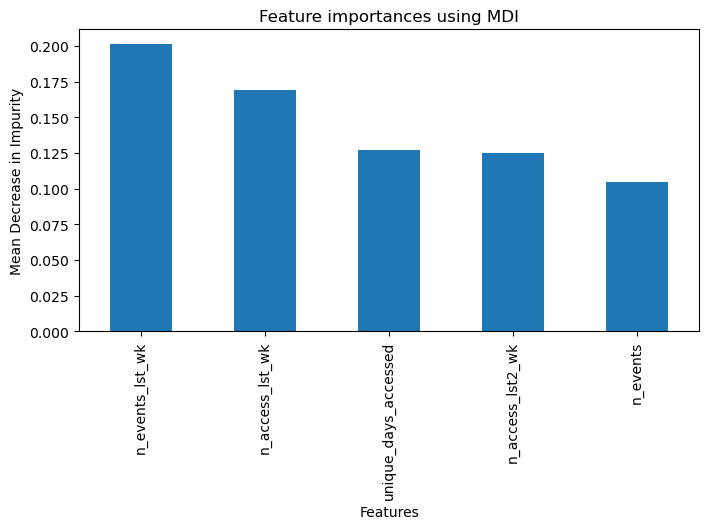

In [279]:
fig = plt.figure(figsize=(8,4), dpi=100)
feature_importances[:5].plot.bar()
plt.title("Feature importances using MDI")
plt.xlabel("Features")
plt.ylabel("Mean Decrease in Impurity")
plt.show()

#### For GradientBoostingClassifier

In [265]:
params = {'n_estimators' : [100,200],
          'learning_rate' : [0.001, 0.01, 0.1],
          'max_depth' : [2,4],
          'min_samples_split' : [2,4],
          'min_samples_leaf' : [2,4]
          } 

grid_search_gbm = GridSearchCV(GradientBoostingClassifier(random_state=8), 
                              params, 
                              verbose=2,
                              n_jobs=-1,
                              cv=5)

grid_search_gbm.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=8),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 4], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 200]},
             verbose=2)

In [266]:
grid_search_gbm.best_estimator_

GradientBoostingClassifier(max_depth=2, min_samples_leaf=4, random_state=8)

In [267]:
grid_search_gbm.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

In [268]:
gbm2 = GradientBoostingClassifier(learning_rate=0.1, max_depth=2, min_samples_leaf=4, min_samples_split=2, n_estimators=100)
gbm2.fit(x_train, y_train)

GradientBoostingClassifier(max_depth=2, min_samples_leaf=4)

In [269]:
y_pred2 = gbm2.predict(x_test)

In [270]:
print("Accuracy :", round(accuracy_score(y_test, y_pred2), 2)*100,"%")
print("Precision :", round(precision_score(y_test, y_pred2), 2))
print("Recall :", round(recall_score(y_test, y_pred2), 2))
print("f1_Score :", round(f1_score(y_test, y_pred2), 2))

Accuracy : 82.0 %
Precision : 0.83
Recall : 0.84
f1_Score : 0.84


In [271]:
print("Confusion Matrix :")
print(confusion_matrix(y_test, y_pred2))

Confusion Matrix :
[[2718  707]
 [ 632 3443]]


In [280]:
# Identify the top 5 important predictors:
feature_importances = pd.Series(gbm2.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

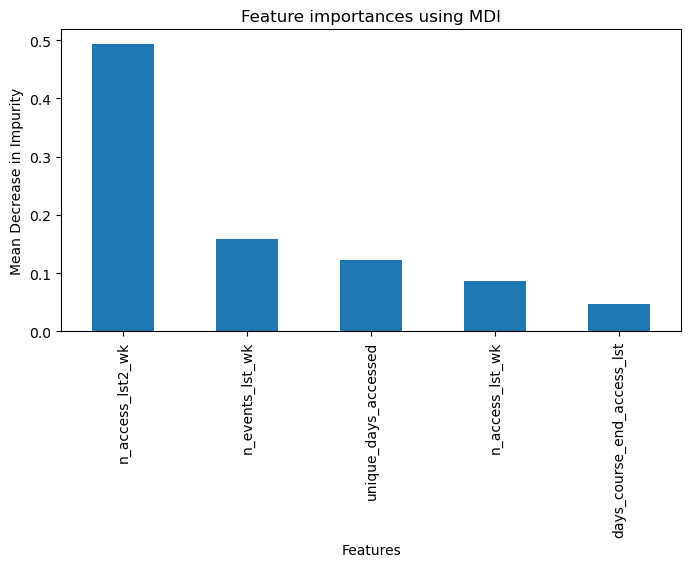

In [281]:
fig = plt.figure(figsize=(8,4), dpi=100)
feature_importances[:5].plot.bar()
plt.title("Feature importances using MDI")
plt.xlabel("Features")
plt.ylabel("Mean Decrease in Impurity")
plt.show()

### Analyzing the Results/Scores

- Even after performing hyper-parameter tunning on Random Forest and GBM almost all the parameters (Accuracy, Precision, Recall and F1-Score) are nearly similar, no significant difference obtained.
- Also we can clearly Identify the top 5 important predictors form the graph plotted above.